In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cell 1 - imports + Google AI setup + simulation params
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
import seaborn as sns
from collections import defaultdict
import math
import json
import os


from kaggle_secrets import UserSecretsClient


GOOGLE_API_KEY = None
try:
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        print("Warning: GOOGLE_API_KEY secret not found or empty in Kaggle secrets.")
except Exception as e:
    print("Warning: could not access Kaggle secrets (UserSecretsClient).", e)

gemini_small = None
gemini_model = None
try:
    import google.generativeai as genai
    if GOOGLE_API_KEY:
        try:
            genai.configure(api_key=GOOGLE_API_KEY)
            print("Google Generative AI SDK configured (API key loaded).")
        except Exception as e:
            print("Warning: genai.configure failed:", e)
    else:
        print("API key not available; genai not configured.")
except Exception as e:
    genai = None
    print("Warning: could not import google.generativeai (genai).", e)

GEMINI_SMALL_MODEL = "models/gemma-3-1b-it"
if 'genai' in globals() and genai is not None and GOOGLE_API_KEY:
    try:
        gemini_small = genai.GenerativeModel(GEMINI_SMALL_MODEL)
        gemini_model = gemini_small  
        print("gemini_small instantiated:", GEMINI_SMALL_MODEL)
    except Exception as e:
        gemini_small = None
        gemini_model = None
        print(f"Warning: could not instantiate {GEMINI_SMALL_MODEL}:", e)
else:
    print("Skipping model instantiation (genai not configured or API key missing).")

# ========= Simulation parameters =========
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

GRID = 25
NUM_CITIZENS = 500
NUM_BUSINESSES = 50
STEPS = 200

OUTPUT_DIR = "sim_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("\n")

print(f"Simulation set: GRID={GRID}, NUM_CITIZENS={NUM_CITIZENS}, NUM_BUSINESSES={NUM_BUSINESSES}, STEPS={STEPS}")
print("\n")

Google Generative AI SDK configured (API key loaded).
gemini_small instantiated: models/gemma-3-1b-it


Simulation set: GRID=25, NUM_CITIZENS=500, NUM_BUSINESSES=50, STEPS=200




In [3]:
# Cell 2: Environment / City class
@dataclass
class City:
    grid: int
    population_map: np.ndarray = field(init=False)
    traffic: np.ndarray = field(init=False)
    pollution: np.ndarray = field(init=False)
    happiness: np.ndarray = field(init=False)
    crime: np.ndarray = field(init=False)
    businesses: np.ndarray = field(init=False)
    employment: np.ndarray = field(init=False)
    logs: List[str] = field(default_factory=list)

    def __post_init__(self):
        g = self.grid
        self.population_map = np.zeros((g, g), dtype=int)
        self.traffic = np.zeros((g, g), dtype=float)
        self.pollution = np.zeros((g, g), dtype=float)
        # baseline happiness initial random about 60-80
        self.happiness = np.random.randint(60, 80, (g, g)).astype(float)
        self.crime = np.zeros((g, g), dtype=float)
        self.businesses = np.zeros((g, g), dtype=int)
        self.employment = np.zeros((g, g), dtype=int)

    def snapshot(self):
        return {
            "population": self.population_map.copy(),
            "traffic": self.traffic.copy(),
            "pollution": self.pollution.copy(),
            "happiness": self.happiness.copy(),
            "crime": self.crime.copy(),
            "businesses": self.businesses.copy(),
            "employment": self.employment.copy()
        }


In [4]:
# Cell 3: Utility helpers
def clamp(x, a=0, b=100):
    return max(a, min(b, x))

def distance(a: Tuple[int,int], b: Tuple[int,int]) -> float:
    return math.hypot(a[0]-b[0], a[1]-b[1])

In [5]:
# Cell 4: Agent definitions
class CitizenAgent:
    _id_counter = 0
    def __init__(self, city: City):
        self.id = CitizenAgent._id_counter
        CitizenAgent._id_counter += 1
        # Place citizen at random location
        self.x = random.randrange(city.grid)
        self.y = random.randrange(city.grid)
        self.wealth = random.gauss(50, 20)  # wealth proxy (0..~100)
        self.job_location = None  # (x,y) or None
        self.happiness = random.randint(50, 80)
        self.risk_tolerance = random.random()  # 0..1
        self.migration_threshold = random.randint(20, 35)  # if happiness lower -> consider leaving
        self.commute_tolerance = random.randint(3, 10)  # preferred commute distance (grid units)
        self.employed = False

    def step(self, city: City, policy_agent):
        # Influence by local traffic and pollution
        loc_traffic = city.traffic[self.x, self.y]
        loc_poll = city.pollution[self.x, self.y]
        # drop happiness due to traffic & pollution
        self.happiness -= (loc_traffic / 100.0) * 2
        self.happiness -= (loc_poll / 100.0) * 1.5

        # if employed, small wealth gain, else small decrease
        if self.employed:
            self.wealth += random.uniform(0, 1.2)
        else:
            self.wealth -= random.uniform(0, 0.8)

        # if unhappy and many steps, may protest or attempt to move
        if self.happiness < (policy_agent.protest_threshold):
            # more likely to protest if low risk_tolerance and low wealth
            if random.random() < 0.02 + (0.5 - self.risk_tolerance) * 0.05:
                city.logs.append(f"Citizen {self.id} staged a protest at ({self.x},{self.y}).")
                self.happiness -= 5

        # movement: seek jobs if unemployed or move randomly
        if not self.employed and random.random() < 0.4:
            # random walk biased towards areas with businesses
            best = self._search_for_better_cell(city, radius=3)
            if best:
                self._move_towards(best, city)
        else:
            # random small move
            if random.random() < 0.2:
                self._random_move(city)
        # update city population map and happiness grid
        city.population_map[self.x, self.y] += 1
        # smooth update of cell happiness
        city.happiness[self.x, self.y] = (city.happiness[self.x, self.y] + self.happiness) / 2.0

        # check migration: leave city if wealth < threshold and unhappiness
        if self.happiness < self.migration_threshold and self.wealth < 5:
            # 30% chance to migrate out
            if random.random() < 0.3:
                city.logs.append(f"Citizen {self.id} migrated out from ({self.x},{self.y}).")
                return "leave"
        return "stay"

    def _random_move(self, city: City):
        dx = random.choice([-1,0,1])
        dy = random.choice([-1,0,1])
        self.x = max(0, min(city.grid-1, self.x + dx))
        self.y = max(0, min(city.grid-1, self.y + dy))

    def _move_towards(self, target, city: City):
        tx, ty = target
        dx = np.sign(tx - self.x)
        dy = np.sign(ty - self.y)
        self.x = int(max(0, min(city.grid-1, self.x + dx)))
        self.y = int(max(0, min(city.grid-1, self.y + dy)))

    def _search_for_better_cell(self, city: City, radius=3):
        best = None
        best_score = -1
        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                nx = self.x + dx
                ny = self.y + dy
                if 0 <= nx < city.grid and 0 <= ny < city.grid:
                    score = city.businesses[nx, ny] - city.traffic[nx, ny]*0.2 + city.happiness[nx, ny]*0.1
                    if score > best_score:
                        best_score = score
                        best = (nx, ny)
        return best

class BusinessAgent:
    _id_counter = 0
    def __init__(self, city: City):
        self.id = BusinessAgent._id_counter
        BusinessAgent._id_counter += 1
        self.x = random.randrange(city.grid)
        self.y = random.randrange(city.grid)
        self.profit = random.uniform(5, 50)
        self.active = True
        self.employees = random.randint(1,5)

    def step(self, city: City):
        # revenue depends on local population and happiness
        customers = city.population_map[self.x, self.y]
        local_happy = city.happiness[self.x, self.y]
        revenue = customers * (0.1 + local_happy/150.0) + random.uniform(-1,3)
        # cost depends on pollution/traffic
        cost = 0.05 * city.pollution[self.x, self.y] + 0.5 * city.traffic[self.x, self.y]
        self.profit += revenue - cost - 0.2*self.employees
        # if profit low for long time, close
        if self.profit < -20:
            self.active = False
            city.logs.append(f"Business {self.id} closed at ({self.x},{self.y}).")
            city.businesses[self.x, self.y] = max(0, city.businesses[self.x, self.y] - 1)
        else:
            # sometimes expand to nearby cell
            if random.random() < 0.01 and self.profit > 50:
                nx = max(0, min(city.grid-1, self.x + random.choice([-1,0,1])))
                ny = max(0, min(city.grid-1, self.y + random.choice([-1,0,1])))
                city.businesses[nx, ny] += 1

class TrafficAgent:
    def step(self, city: City):
        # traffic increases where population is high and businesses attract people
        base = city.population_map * 0.5 + city.businesses * 3.0
        # diffusion to neighbors and random jitter
        new_traffic = np.copy(city.traffic) * 0.6 + base * 0.4 + np.random.rand(city.grid, city.grid) * 2.0
        new_traffic = np.clip(new_traffic, 0, 100)
        # occasional congestion events
        if random.random() < 0.02:
            sx = random.randrange(city.grid)
            sy = random.randrange(city.grid)
            new_traffic[sx, sy] = clamp(new_traffic[sx, sy] + random.uniform(20, 60))
            city.logs.append(f"Traffic jam at ({sx},{sy}).")
        city.traffic = new_traffic

class EnvironmentAgent:
    def step(self, city: City):
        # pollution increases with traffic and business density, decays slowly
        produced = city.traffic * 0.6 + city.businesses * 3.0
        decay = 1.0  # natural decay
        new_poll = np.copy(city.pollution) * 0.9 + produced * 0.05 - decay * 0.3 + np.random.rand(city.grid, city.grid) * 1.5
        city.pollution = np.clip(new_poll, 0, 100)

class CrimeAgent:
    def step(self, city: City):
        # crime grows in zones of low happiness and high density
        hazard = (100 - city.happiness) * 0.6 + city.population_map * 0.5 + city.pollution * 0.1
        # noise and thresholding
        city.crime = np.clip(hazard * np.random.rand(city.grid, city.grid) / 50.0, 0, 100)

class PolicyAgent:
    def __init__(self):
        self.tax = 5.0  # percent
        self.public_transport_funding = 5.0  # arbitrary units
        self.protest_threshold = 35.0  # happiness threshold below which protests more likely
        self.history = []

    def step(self, city: City, step_idx: int):
        # --- compute current metrics (use city arrays, safe) ---
        avg_happy = float(city.happiness.mean())
        avg_poll = float(city.pollution.mean())
        avg_traffic = float(city.traffic.mean())
        avg_crime = float(city.crime.mean())
        # count businesses from the city's business grid (safe)
        active_businesses = int(np.sum(city.businesses))

        # --- fallback local policy (use if Gemini not available or fails) ---
        def fallback_policy():
            if avg_happy < 50:
                self.public_transport_funding += 0.5
                if self.tax > 2:
                    self.tax -= 0.5
                city.logs.append(
                    f"[FallbackPolicy] Increased PT funding to {self.public_transport_funding:.1f}, tax {self.tax:.1f}"
                )
            else:
                self.tax += 0.2
                city.logs.append(f"[FallbackPolicy] Raised tax to {self.tax:.1f}")
            if avg_poll > 50:
                self.public_transport_funding += 1.0
                city.logs.append("[FallbackPolicy] Pollution high -> boosting green fund")

        
        if 'gemini_model' in globals() and gemini_model is not None:
            prompt = f"""
You are an AI policy advisor. Return a single JSON object ONLY:
{{"tax_change": number, "transport_funding_change": number, "comment": "short text"}}

City metrics:
avg_happiness: {avg_happy}
avg_pollution: {avg_poll}
avg_traffic: {avg_traffic}
avg_crime: {avg_crime}
active_businesses: {active_businesses}
current_tax: {self.tax}
current_pt_fund: {self.public_transport_funding}
"""
            try:
                resp = gemini_model.generate_content(prompt)
                raw = resp.text.strip() if hasattr(resp, "text") else str(resp).strip()

                # Robust JSON extraction: extract first {...} block if model adds commentary
                start = raw.find('{')
                end = raw.rfind('}') + 1
                json_text = raw[start:end] if start != -1 and end != -1 else raw

                policy = json.loads(json_text)
                tax_delta = float(policy.get("tax_change", 0.0))
                pt_delta = float(policy.get("transport_funding_change", 0.0))
                comment = policy.get("comment", "")

                # apply changes with sensible clamping
                self.tax = max(0.0, min(100.0, self.tax + tax_delta))
                self.public_transport_funding = max(0.0, self.public_transport_funding + pt_delta)
                city.logs.append(f"[AI Policy] {comment} (tax={self.tax:.1f}, pt_fund={self.public_transport_funding:.1f})")
            except Exception as e:
                city.logs.append(f"[AI Policy ERROR] {e}; using fallback.")
                fallback_policy()
        else:
            # No model configured — use fallback rules
            fallback_policy()

        # --- record history ---
        self.history.append({
            "step": step_idx,
            "avg_happy": avg_happy,
            "tax": self.tax,
            "pt_fund": self.public_transport_funding,
            "avg_poll": avg_poll,
            "avg_traffic": avg_traffic,
            "avg_crime": avg_crime
        })

class EmergentEventAgent:
    def step(self, city: City, step_idx: int):
        # random rare events with consequences
        p = random.random()
        if p < 0.01:
            # earthquake: big negative effect and population displacement locally
            cx = random.randrange(city.grid)
            cy = random.randrange(city.grid)
            city.pollution[cx, cy] = clamp(city.pollution[cx, cy] + 30)
            city.happiness[cx, cy] = clamp(city.happiness[cx, cy] - 30)
            city.logs.append(f"Earthquake at ({cx},{cy}) causing local disruption.")
        elif p < 0.02:
            # festival: happiness boost in region
            cx = random.randrange(city.grid)
            cy = random.randrange(city.grid)
            city.happiness = np.clip(city.happiness + 5 * np.exp(-((np.indices((city.grid,city.grid))[0]-cx)**2 + (np.indices((city.grid,city.grid))[1]-cy)**2)/20.0), 0, 100)
            city.logs.append(f"Festival at ({cx},{cy}) increased happiness nearby.")
        elif p < 0.025:
            # disease outbreak: decrease happiness and population
            cx = random.randrange(city.grid)
            cy = random.randrange(city.grid)
            lost = int(city.population_map[cx,cy] * 0.2)
            city.population_map[cx,cy] = max(0, city.population_map[cx,cy] - lost)
            city.happiness[cx,cy] = clamp(city.happiness[cx,cy] - 20)
            city.logs.append(f"Disease outbreak at ({cx},{cy}), population decreased by {lost}.")


In [6]:
# Cell 5 - checks for required globals/classes and initializes the world.

# --- 1) Ensure basic global params exist, otherwise set defaults (warn user) ---
defaults_used = []
if 'GRID' not in globals():
    GRID = 25
    defaults_used.append("GRID=25")
if 'NUM_CITIZENS' not in globals():
    NUM_CITIZENS = 500
    defaults_used.append("NUM_CITIZENS=500")
if 'NUM_BUSINESSES' not in globals():
    NUM_BUSINESSES = 50
    defaults_used.append("NUM_BUSINESSES=50")

if defaults_used:
    print("Warning: some globals were not defined; using defaults ->", ", ".join(defaults_used))
    print("Recommended: run the top cells (Cell 1 etc.) so these values come from your original config.")

required_names = ["City", "CitizenAgent", "BusinessAgent", "TrafficAgent",
                  "EnvironmentAgent", "CrimeAgent", "PolicyAgent", "EmergentEventAgent"]
missing = [name for name in required_names if name not in globals()]
if missing:
    raise RuntimeError(
        "The following classes/definitions are missing and must be defined before running this cell:\n"
        + ", ".join(missing)
        + "\n\nPlease run Cells 1-4 (or the notebook from the top) so these classes are defined."
    )

# --- 3) Now initialize city and agents (safe) ---
city = City(GRID)

# Create initial businesses distribution
business_list = []
for _ in range(NUM_BUSINESSES):
    b = BusinessAgent(city)
    business_list.append(b)
    city.businesses[b.x, b.y] += 1

# Create citizens
citizens: List[CitizenAgent] = []
for _ in range(NUM_CITIZENS):
    c = CitizenAgent(city)
    citizens.append(c)

# System / environment agents
traffic_agent = TrafficAgent()
env_agent = EnvironmentAgent()
crime_agent = CrimeAgent()
policy_agent = PolicyAgent()
event_agent = EmergentEventAgent()

# Bookkeeping for time series
time_series = defaultdict(list)
snapshots = []
print("\n")
print(f"Initialized: GRID={GRID}, citizens={len(citizens)}, businesses={len(business_list)}")
print("\n")



Initialized: GRID=25, citizens=500, businesses=50




In [7]:
# Cell 6: Simulation Loop

if 'STEPS' not in globals():
    STEPS = 200
    print("Warning: STEPS not defined. Defaulting to STEPS =", STEPS)

AI_USED = False 

for t in range(STEPS):

    # reset per-step population map
    city.population_map = np.zeros((city.grid, city.grid), dtype=int)
    city.logs.append(f"--- Step {t} ---")

    # Citizens act
    survivors = []
    for c in citizens:
        status = c.step(city, policy_agent)
        if status == "stay":
            survivors.append(c)
    citizens = survivors

    # Businesses act
    for b in business_list:
        if b.active:
            b.step(city)
        else:
            if random.random() < 0.01:
                b.active = True
                b.profit = random.uniform(5, 20)
                city.logs.append(f"Business {b.id} reopened at ({b.x},{b.y}).")

    # Rebuild businesses grid
    city.businesses[:] = 0
    for b in business_list:
        if b.active:
            city.businesses[b.x, b.y] += 1

    # Core environment pipeline
    traffic_agent.step(city)
    env_agent.step(city)
    crime_agent.step(city)
    policy_agent.step(city, t)
    event_agent.step(city, t)

    if (not AI_USED) and ('gemini_model' in globals()) and (gemini_model is not None):
        try:
            ai_prompt = f"""
You are an AI city expert. 
Give 1 short sentence (max 20-25 words) summarizing the city's early condition.

Metrics:
- Avg happiness: {city.happiness.mean():.2f}
- Pollution: {city.pollution.mean():.2f}
- Traffic: {city.traffic.mean():.2f}
- Crime: {city.crime.mean():.2f}
- Population: {len(citizens)}
"""
            ai_resp = gemini_model.generate_content(ai_prompt)
            ai_msg = ai_resp.text if hasattr(ai_resp, "text") else str(ai_resp)

            print("\n --> AI Insight:", ai_msg, "\n")
            AI_USED = True

        except Exception as e:
            print("\n !! AI Insight failed:", e, "\n")
            AI_USED = True 

    # Employment updates
    for b in business_list:
        if b.active:
            pop_here = city.population_map[b.x, b.y]
            if pop_here > 5 and random.random() < 0.05:
                b.employees += 1
            if pop_here < 1 and b.employees > 0 and random.random() < 0.02:
                b.employees -= 1

    # rebuild employment grid
    city.employment[:] = 0
    for b in business_list:
        if b.active and b.employees > 0:
            city.employment[b.x, b.y] += b.employees

    # clamp values
    city.happiness = np.clip(city.happiness, 0, 100)
    city.pollution = np.clip(city.pollution, 0, 100)
    city.traffic = np.clip(city.traffic, 0, 100)
    city.crime = np.clip(city.crime, 0, 100)

    # record metrics
    time_series['avg_happiness'].append(float(city.happiness.mean()))
    time_series['avg_pollution'].append(float(city.pollution.mean()))
    time_series['avg_traffic'].append(float(city.traffic.mean()))
    time_series['avg_crime'].append(float(city.crime.mean()))
    time_series['population'].append(len(citizens))
    time_series['active_businesses'].append(int(np.sum(city.businesses)))

    # save snapshot every 10 steps
    if t % 10 == 0:
        snapshots.append(city.snapshot())



 --> AI Insight: Okay, here’s a one-sentence summary reflecting the city’s early condition, based on the provided metrics:

Despite a relatively low happiness score and noticeable challenges like high pollution and traffic, the city boasts a vibrant population of 500. 



In [8]:
# Cell 7: Post-Simulation Summary

required = {
    "city": "City instance (city)",
    "citizens": "list of CitizenAgent (citizens)",
    "business_list": "list of BusinessAgent (business_list)",
    "policy_agent": "PolicyAgent instance (policy_agent)"
}
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError("Missing objects required by Cell 7: " + ", ".join(missing))

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Build summary dictionary ---
summary = {
    "final_population": int(len(citizens)),
    "avg_happiness_final": float(city.happiness.mean()),
    "avg_pollution_final": float(city.pollution.mean()),
    "avg_traffic_final": float(city.traffic.mean()),
    "avg_crime_final": float(city.crime.mean()),
    "active_businesses": int(np.sum(city.businesses))
}

print("=== Simulation Summary ===")
print(json.dumps(summary, indent=2))

try:
    logs_path = os.path.join(OUTPUT_DIR, "city_logs.txt")
    with open(logs_path, "w", encoding="utf-8") as f:
        for line in city.logs[-1000:]:
            f.write(line + "\n")
    print(f"[Saved] logs -> {logs_path}")
except Exception as e:
    print("Error saving logs:", e)

try:
    history = getattr(policy_agent, "history", None)
    if history:
        policy_path = os.path.join(OUTPUT_DIR, "policy_history.csv")
        pd.DataFrame(history).to_csv(policy_path, index=False)
        print(f"[Saved] policy history -> {policy_path}")
    else:
        print("Note: No policy history available.")
except Exception as e:
    print("Error saving policy history:", e)

final_report_path = os.path.join(OUTPUT_DIR, "final_report.txt")

try:
    with open(final_report_path, "w", encoding="utf-8") as f:
        f.write("FINAL CITY REPORT\n")
        f.write("=====================================\n\n")
        f.write("Key Metrics:\n")
        for k, v in summary.items():
            f.write(f"- {k}: {v}\n")

        f.write("\nAnalysis Notes:\n")
        f.write(f"* Citizens present: {len(citizens)}\n")
        f.write(f"* Businesses active: {int(np.sum(city.businesses))}\n")
        f.write(f"* City happiness trend appears {'low' if city.happiness.mean()<50 else 'moderate'}.\n")

    print(f"[Saved] summary report -> {final_report_path}")

except Exception as e:
    print("Error writing final report:", e)

print("\nCell 7 completed successfully (no AI calls).")

=== Simulation Summary ===
{
  "final_population": 352,
  "avg_happiness_final": 36.79870173470118,
  "avg_pollution_final": 5.3351561973419495,
  "avg_traffic_final": 2.795901693182457,
  "avg_crime_final": 0.36887799908021596,
  "active_businesses": 8
}
[Saved] logs -> sim_outputs/city_logs.txt
[Saved] policy history -> sim_outputs/policy_history.csv
[Saved] summary report -> sim_outputs/final_report.txt

Cell 7 completed successfully (no AI calls).


=== Numeric summaries & top-5 hotspots ===

Pollution: mean=5.34, median=5.31, max=13.70
  Top1: (20, 8) = 13.7
  Top2: (11, 18) = 8.7
  Top3: (3, 12) = 8.3
  Top4: (19, 10) = 8.1
  Top5: (20, 15) = 8.1

Traffic: mean=2.80, median=2.68, max=25.01
  Top1: (8, 23) = 25.0
  Top2: (17, 24) = 6.2
  Top3: (18, 2) = 6.0
  Top4: (1, 18) = 6.0
  Top5: (12, 11) = 5.9

Happiness: mean=36.80, median=37.34, max=47.12
  Top1: (9, 8) = 47.1
  Top2: (24, 19) = 46.6
  Top3: (10, 23) = 46.3
  Top4: (2, 17) = 45.9
  Top5: (20, 6) = 45.9

Crime: mean=0.37, median=0.37, max=0.90
  Top1: (2, 19) = 0.9
  Top2: (22, 5) = 0.8
  Top3: (5, 1) = 0.8
  Top4: (7, 3) = 0.8
  Top5: (12, 6) = 0.8

Population: mean=0.57, median=0.00, max=8.00, total=354
  Top1: (1, 18) = 8.0
  Top2: (8, 4) = 8.0
  Top3: (1, 19) = 6.0
  Top4: (13, 19) = 5.0
  Top5: (20, 9) = 5.0


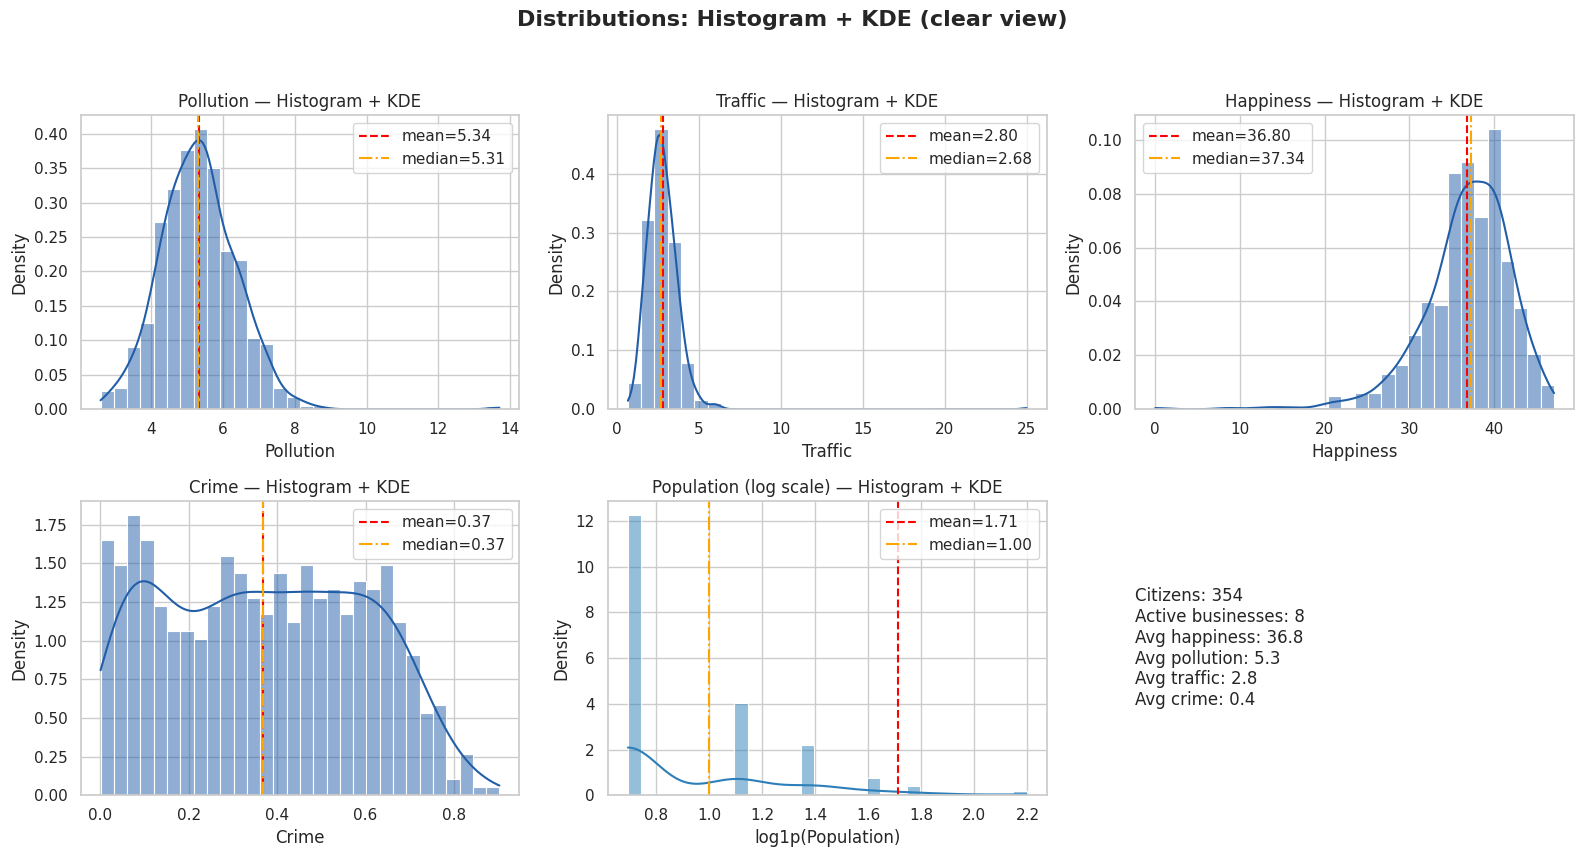


[Saved] sim_outputs/hist_kde_overview.png


In [9]:
# Cell 8: Visualizations ( Final State)

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set(style="whitegrid", context="notebook")

metrics = {
    "pollution": ("Pollution", city.pollution),
    "traffic": ("Traffic", city.traffic),
    "happiness": ("Happiness", city.happiness),
    "crime": ("Crime", city.crime),
    "population": ("Population", city.population_map)
}

def top_k_cells(mat, k=5):
    arr = np.array(mat).astype(float)
    flat = arr.flatten()
    idxs = np.argsort(flat)[-k:][::-1]
    coords = []
    ncols = arr.shape[1]
    for idx in idxs:
        val = float(flat[idx])
        if val <= 0:
            continue
        x = int(idx // ncols); y = int(idx % ncols)
        coords.append(((x,y), val))
    return coords

# Print numeric summaries & top cells
print("=== Numeric summaries & top-5 hotspots ===")
for key, (label, M) in metrics.items():
    arr = np.array(M, dtype=float)
    mean = float(np.nanmean(arr))
    med = float(np.nanmedian(arr))
    mx = float(np.nanmax(arr))
    extra = f", total={int(arr.sum())}" if key == "population" else ""
    print(f"\n{label}: mean={mean:.2f}, median={med:.2f}, max={mx:.2f}{extra}")
    tops = top_k_cells(arr, k=5)
    if tops:
        for i, (coord, val) in enumerate(tops, 1):
            print(f"  Top{i}: {coord} = {val:.1f}")
    else:
        print("  No positive hotspots found.")

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()
plot_keys = list(metrics.keys())

for i, key in enumerate(plot_keys):
    ax = axes[i]
    label, M = metrics[key]
    arr = np.array(M, dtype=float).flatten()
    if key == "happiness":
        data = arr[~np.isnan(arr)]
    else:
        data = arr[arr > 0] 
    if data.size == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
        ax.set_title(label)
        continue

    if key == "population":
        plot_data = np.log1p(data)
        sns.histplot(plot_data, kde=True, ax=ax, stat='density', bins=30, color="#2c7fb8")
        ax.set_xlabel("log1p(Population)")
        ax.set_title(f"{label} (log scale) — Histogram + KDE")
    else:
        sns.histplot(data, kde=True, ax=ax, stat='density', bins=30, color="#225ea8")
        ax.set_xlabel(label)
        ax.set_title(f"{label} — Histogram + KDE")

    mean = np.nanmean(data)
    med = np.nanmedian(data)
    ax.axvline(mean, color="red", linestyle="--", linewidth=1.5, label=f"mean={mean:.2f}")
    ax.axvline(med, color="orange", linestyle="-.", linewidth=1.5, label=f"median={med:.2f}")
    ax.legend()

axes[-1].axis('off')
summary_text = (
    f"Citizens: {np.sum(city.population_map)}\n"
    f"Active businesses: {sum(1 for b in business_list if b.active)}\n"
    f"Avg happiness: {city.happiness.mean():.1f}\n"
    f"Avg pollution: {city.pollution.mean():.1f}\n"
    f"Avg traffic: {city.traffic.mean():.1f}\n"
    f"Avg crime: {city.crime.mean():.1f}"
)
axes[-1].text(0, 0.5, summary_text, fontsize=12, va='center')

plt.suptitle("Distributions: Histogram + KDE (clear view)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

outpath = os.path.join(OUTPUT_DIR, "hist_kde_overview.png")
plt.savefig(outpath, dpi=220, bbox_inches='tight')
plt.show()
print(f"\n[Saved] {outpath}")


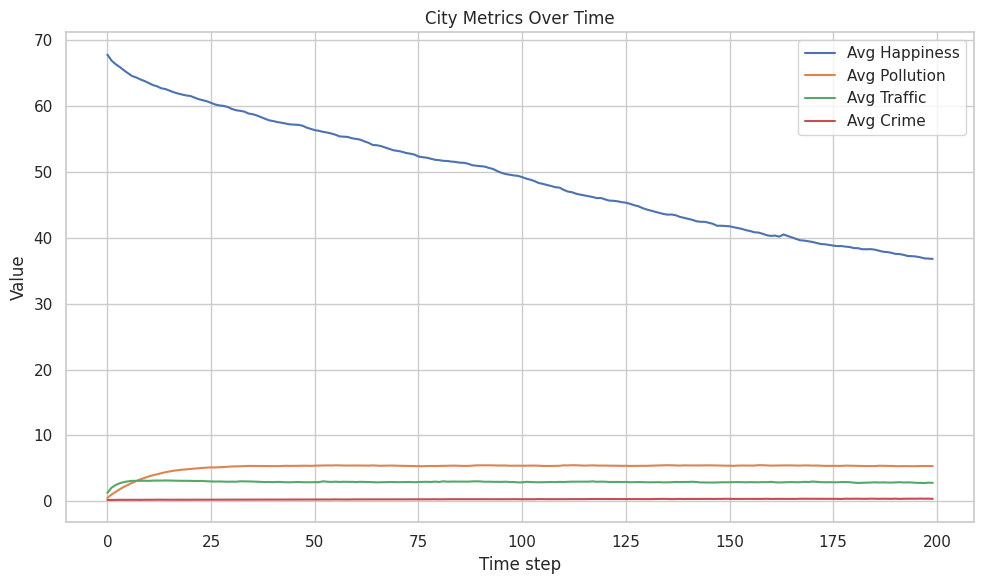

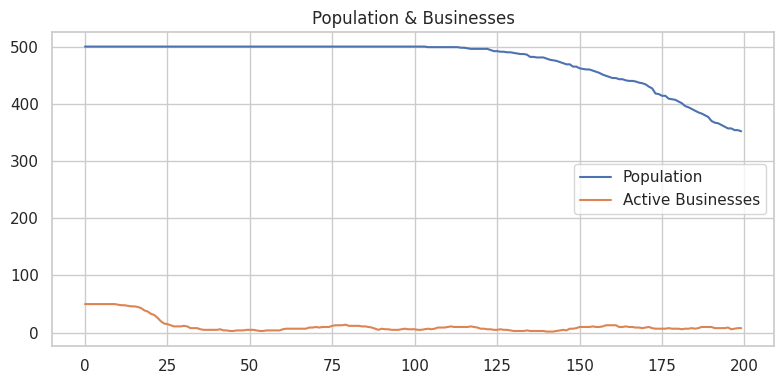

In [10]:
# Cell 9: Visualizations - Time series
plt.figure(figsize=(10,6))
plt.plot(time_series['avg_happiness'], label='Avg Happiness')
plt.plot(time_series['avg_pollution'], label='Avg Pollution')
plt.plot(time_series['avg_traffic'], label='Avg Traffic')
plt.plot(time_series['avg_crime'], label='Avg Crime')
plt.legend()
plt.title("City Metrics Over Time")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_timeseries.png"))
plt.show()

plt.figure(figsize=(8,4))
plt.plot(time_series['population'], label='Population')
plt.plot(time_series['active_businesses'], label='Active Businesses')
plt.legend()
plt.title("Population & Businesses")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pop_business_timeseries.png"))
plt.show()

In [11]:
# Cell 10: Save snapshots
np.savez_compressed(os.path.join(OUTPUT_DIR, "final_state.npz"),
                    population=city.population_map,
                    traffic=city.traffic,
                    pollution=city.pollution,
                    happiness=city.happiness,
                    crime=city.crime,
                    businesses=city.businesses)

pd.DataFrame([summary]).to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# save a short agent log sample for inspection
with open(os.path.join(OUTPUT_DIR, "agent_log_sample.txt"), "w") as f:
    for l in city.logs[-500:]:
        f.write(l + "\n")

print(f"Outputs saved to {OUTPUT_DIR}/ (Histogram+KDE Plot, timeseries, logs, npz, csv)")


Outputs saved to sim_outputs/ (Histogram+KDE Plot, timeseries, logs, npz, csv)


In [12]:
with open("sim_outputs/final_report.txt", "r") as f:
    print(f.read())

FINAL CITY REPORT

Key Metrics:
- final_population: 352
- avg_happiness_final: 36.79870173470118
- avg_pollution_final: 5.3351561973419495
- avg_traffic_final: 2.795901693182457
- avg_crime_final: 0.36887799908021596
- active_businesses: 8

Analysis Notes:
* Citizens present: 352
* Businesses active: 8
* City happiness trend appears low.



In [13]:
import pandas as pd
pd.read_csv("sim_outputs/policy_history.csv").head()

,step,avg_happy,tax,pt_fund,avg_poll,avg_traffic,avg_crime
0,0,67.820700,5.0,5.0,0.512306,1.286361,0.193750
1,1,66.906699,5.0,5.0,1.021918,2.053182,0.196501
2,2,66.366785,5.0,5.0,1.427285,2.470541,0.205219
3,3,65.923953,5.0,5.0,1.828125,2.738609,0.220185
4,4,65.433953,5.0,5.0,2.192975,2.910653,0.209497


In [14]:
with open("sim_outputs/city_logs.txt", "r") as f:
    print(f.read()[:1200])   # show first 1200 characters


--- Step 20 ---
Business 6 closed at (13,7).
Business 12 closed at (2,17).
Business 31 closed at (19,2).
Business 48 closed at (22,9).
[AI Policy] Overall city metrics indicate a generally positive environment with moderate levels of congestion and crime. (tax=5.0, pt_fund=5.0)
--- Step 21 ---
Business 10 closed at (11,19).
Business 13 closed at (11,18).
[AI Policy] Overall, the city exhibits a relatively stable economic environment with moderate levels of social and environmental challenges. (tax=5.0, pt_fund=5.0)
--- Step 22 ---
Business 17 closed at (5,11).
Business 19 closed at (20,5).
Business 21 closed at (7,21).
Business 25 closed at (12,20).
Business 26 closed at (4,7).
[AI Policy] Overall, the city exhibits a relatively stable economic environment with moderate levels of social and environmental challenges. (tax=5.0, pt_fund=5.0)
--- Step 23 ---
Business 1 closed at (7,7).
Business 5 closed at (17,6).
Business 7 closed at (0,24).
Business 11 closed at (23,14).
Business 35 clos